# dacl-demo

In this demo-notebook we will be importing a dacl model for the **Multi-Target Classification** of damage on reinforced concrete structures. 
All steps for feeding the dacl with tasty images of damage will be examined:

1. ***Instantiate the dacl-model:*** First, the model must be instantiated by Dacl class. Currently there are three architectures available based on: ResNet 50, EfficientNet and MobileNetV3_large.
2. ***Preprocess the image***: Before feeding the dacl-model we need to prepare the image. Our dacl models are very picky regarding his food.
3. ***Feed the dacl-model***: Finally, feed the dacl-model with tasty preprocessed image data.
4. ***Analyze the results***: Analyze the dacl-model's results and try to interpret them.


## Imports
Initially, we have to import the modules, we want to use.

In [1]:
import numpy as np
import torch
from torch import nn
from torchvision import models

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import MemoryEfficientSwish

from PIL import Image
import matplotlib.pyplot as plt
import json
from pathlib import Path

%matplotlib inline

## 1. Instantiate the dacl-model

First, the model must be instantiated by Dacl class. Currently there are three architectures available based on: ResNet 50, EfficientNet and MobileNetV3_large.

In [8]:
# Dict to find the suiting EfficientNet model according to the resolution of the input-images:
efnet_dict = {'b0': 224, 'b1': 240, 'b2': 260, 'b3': 300,   
              'b4': 380, 'b5': 456, 'b6': 528, 'b7': 600    
             }

class DaclNet(nn.Module):
    def __init__(self, base_name, resolution, hidden_layers, num_class, drop_prob=0.2, freeze_base=True):
        ''' Builds a network with a base model and a classifier with arbitrary hidden layers.
        
            Attributes
            ---------
            base_name: string, basemodel for the NN
            resolution: resolution of the input-images, example: 224, 240...(look efnet_dic), Only needed for EfficientNet
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_prob: float, dropout probability
            freeze_base: boolean, choose if you want to freeze the parameters of the base model
            num_class: integer, size of the output layer according to the number of classes

            Example
            ---------
            model = Network(base_name='efficientnet', resolution=224, hidden_layers=[32,16], num_class=6, drop_prob=0.2, freeze_base=True)

            Note
            ---------
            -print(efficientnet) -> Last module: (_swish): MemoryEfficientSwish() and the last fc-layers
             Don't worry! Won't be called during forward due to: "self.base.extract_features"! No activation of last layer!
        '''
        super(DaclNet, self).__init__()
        # basemodel
        self.base_name = base_name
        self.resolution = resolution
        self.hidden_layers = hidden_layers
        self.freeze_base = freeze_base

        if self.base_name == 'mobilenet':
            base = models.mobilenet_v3_large(pretrained=True) 
            modules = list(base.children())[:-1] 
            self.base = nn.Sequential(*modules)
            # for pytorch model:
            if hidden_layers:
                self.classifier = nn.ModuleList([nn.Linear(base.classifier[0].in_features, self.hidden_layers[0])]) #Input features = depth of the last BatchNorm layer = input features of first layer of original classifier
            else:
                self.classifier = nn.Linear(base.classifier[0].in_features, num_class)

            self.activation = nn.Hardswish()

        elif self.base_name == 'resnet':
            base = models.resnet50(pretrained=True) 
            modules = list(base.children())[:-1]
            self.base = nn.Sequential(*modules)
            if self.hidden_layers:
                self.classifier = nn.ModuleList([nn.Linear(base.fc.in_features, self.hidden_layers[0])])
            else:
                self.classifier = nn.Linear(base.fc.in_features, num_class)   
            self.activation = nn.ELU() # Eliminates dying RELU problem according to: https://tungmphung.com/elu-activation-a-comprehensive-analysis/

        elif self.base_name == 'efficientnet':      # Implementing Effnet the same way like the others didn't work, because omitting the last module also removes last batchnorm, avg-pooling
            for ver in efnet_dict:
                if efnet_dict[ver] == self.resolution:
                    self.version = ver
                    full_name = self.base_name+'-'+ver
            self.base = EfficientNet.from_pretrained(model_name=full_name) 
            if self.hidden_layers:
                self.classifier = nn.ModuleList([nn.Linear(self.base._fc.in_features, self.hidden_layers[0])])
            else:
                self.classifier = nn.Linear(self.base._fc.in_features, num_class)   
            self.activation = MemoryEfficientSwish()
        elif self.base_name == 'mobilenetv2':
            base = models.mobilenet.mobilenet_v2(pretrained=True)
            print(base)
            modules = list(base.children())[:-1]
            self.base = nn.Sequential(*modules)
            if hidden_layers:
                self.classifier = nn.ModuleList([nn.Linear(base.classifier[1].in_features, self.hidden_layers[0])]) #Input features = depth of the last BatchNorm layer = input features of first layer of original classifier
            else:
                self.classifier = nn.Linear(base.classifier[1].in_features, num_class)
            self.activation = nn.ReLU()
 

        else:
            raise NotImplementedError    
        
        # freeze the base
        if self.freeze_base:
            for param in self.base.parameters(): 
                param.requires_grad_(False)
        
        self.dropout = nn.Dropout(p=drop_prob, inplace=True)

        # classifier
        # Add a variable number of more hidden layers
        if self.hidden_layers:
            layer_sizes = zip(self.hidden_layers[:-1], self.hidden_layers[1:])        # The default baseV3Large model has one hidden layer with 1280 nodes
            self.classifier.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
            # add output layer to classifier
            self.classifier.append(nn.Linear(self.hidden_layers[-1], num_class))
        else:
            pass
        
    def forward(self, input_batch):
        '''
        Every model uses 2d-Average-Pooling wit output_size 1 after the feature extraction and before flattening
        The pooling layer of ResNet50 and MobileNetV3 was kept in the squential -> Doesn't have to be called in forward!
        EffNet had to be implemented with the AdaptiveAvgpool2d in this forward function because of missing pooling when
        calling: "effnet.extract_features(input_batch)"
        Also mobilenetV2 needs the manually added pooling layer
        '''
        # Check if model is one that needs Pooling layer
        if self.base_name in ['efficientnet', 'mobilenetv2']:
            if self.base_name == 'efficientnet':
                x = self.base.extract_features(input_batch)
            else:
                # For MobileNetV2
                x= self.base(input_batch)
            pool = nn.AdaptiveAvgPool2d(1)
            x = pool(x)
        else:
            # For any other model don't additionally apply pooling:
            x = self.base(input_batch)
        
        x = self.dropout(x)     # Originally only in EfficientNet a Dropout is aplied after last bottleneck, in others not!  
        x = x.view(x.size(0), -1)   # Or: x.flatten(start_dim=1)
        if self.hidden_layers:    
            for i,each in enumerate(self.classifier):
                if i < len(self.classifier)-1:
                    x = self.activation(each(x))
                    x = self.dropout(x)
                else:
                    logits = each(x)
                    # print('After this layer no activation follows')
                    # print('=======Next Batch========')
                    break
        else:
            logits = self.classifier(x)

        return logits


## 2. Preprocess the image

Before feeding the dacl-model we need to prepare the image. Our dacl models are very picky regarding their food.
We have to get a image transformed to a tensor with the shape *N x C x H x W* where *N* is the batch-size, *C* the color channels (RGB), *H* the height and *W* the width of the image. 

The datatype of the preprocessed image is: torch.float32 and it's shape is: torch.Size([1, 3, 224, 224])


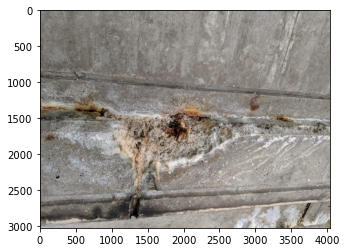

In [9]:
# Preprocessing-function:
def process_img(img_path=False):
	''' Scales, crops, and normalizes a PIL image for a PyTorch model,
	returns a Torch Tensor
	Args: 
		filepath: 	filepath of the image (string)
			Example: 'test/1/image_06743.jpg'
	Returns: torch.float32 of shape: [1, 3, 224, 224]
	'''

	if not img_path:
		print('Parse the filename of the image!')
	else:
		#Parse image as PIL Image
		image = Image.open(img_path)
		# Setting Resize Parameters (width and height)
		image_ratio = image.height / image.width
		if  image.width < image.height  or image.width > image.height:
			if image.width < image.height:
				resize = (256, int(image_ratio * 256))
			else:
				resize = (int(256 / image_ratio), 256)
		else:
			resize = (256, 256)
		
		#Setting Crop parameters
		crop_size = 224
		crop_x = int((resize[0] - crop_size) / 2)
		crop_y = int((resize[1] - crop_size) / 2)
		crop_box = (crop_x, crop_y,crop_x + crop_size, crop_y+crop_size)
	  	
		#Transformation
		pil_image = image.resize(resize)
		pil_image = pil_image.crop(crop_box)
		np_image = np.array(pil_image)
		np_image = (np_image/255 - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
		np_image = np_image.transpose(2,0,1)
		image = torch.from_numpy(np_image)
		image = image.unsqueeze_(0)
		image = image.type(torch.FloatTensor)
		return image


# Get image and show it:
img = plt.imread('assets/11_008121.jpg')
plt.imshow(img)

# Preprocess:
img_proc = process_img('assets/11_008121.jpg')
print("The datatype of the preprocessed image is: {} and it's shape is: {}".format(img_proc.dtype, img_proc.shape))

## 3. Feed the dacl-model
Finally, Load a checkpoint of your choice and feed the dacl-model with tasty preprocessed image data.

**Choose a checkpoint from the table beyond**

## Available Models

| Modelname             | Dataset           | EMR   | F1   | Tag          | Checkpoint                |
|-----------------------|-------------------|-------|------|--------------|---------------------------|
| Code_res_dacl         | codebrim_balanced | 73.73 | 0.85 | ResNet       | Code_res_dacl.pth         |
| Code_mobilev2_dacl    | codebrim_balanced |70.41  | 0.84 | MobileNetV2  | Code_mobilev2_dacl.pth    |
| Code_mobile_dacl      | codebrim_balanced | 69.46 | 0.83 | MobileNet    | Code_mobile_dacl.pth      |
| Code_eff_dacl         | codebrim_balanced | 68.67 | 0.84 | EfficientNet | Code_eff_dacl.pth         |
| McdsBikit_mobile_dacl | mcds_Bikit        | 54.44 | 0.66 | MobileNet    | McdsBikit_mobile_dacl.pth |
| McdsBikit_eff_dacl    | mcds_Bikit        | 51.85 | 0.65 | EfficientNet | McdsBikit_eff_dacl.pth    |
| McdsBikit_res_dacl    | mcds_Bikit        | 48.15 | 0.62 | ResNet       | McdsBikit_res_dacl.pth    |


In [17]:
# Choose which checkpoint/model you want to load from the table above:
cp_name = 'meta4_hta_mobilenet_silvery-firefly-11.pth'

cp = torch.load('models/' + cp_name) 
model = DaclNet(base_name=cp['base'], resolution = cp['resolution'], hidden_layers=cp['hidden_layers'], 
				drop_prob=cp['drop_prob'], num_class=cp['num_class'])
model.load_state_dict(cp['state_dict'])
model.eval()
print(model)
# Now let's feed the dacl-model in order to  classify the image that we imported at the beginning:
logits = model(img_proc)

# Apply sigmoid activation to get predictions:
preds = torch.sigmoid(logits).float()

# Binarize results:
threshold = .5 # Which threshold do you want to choose for binarization of predictions (for bikit .5 was chosen)
bin = np.array(preds.squeeze(0) > threshold, dtype=float)

# Here are our damage-class-names stored with the according position in the output vector:
with open('cat_to_name.json', 'r') as f:
	cat_to_name = json.load(f)[cp['dataset']]
	print('Position and name of class according to the order in the output cvector:\n', cat_to_name)

# Output:
# print('This is the model you have just created:\n', model)
print('*'*10, 'Output', '*'*10)
print('Predictions: ', preds)
print('Binarized Output: ', bin)
for i,r in enumerate(bin):
	if r != 0:
		print(i, ': ', cat_to_name[str(i)]) 

DaclNet(
  (base): Sequential(
    (0): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(


## Analyze the results
Analyze the dacl-model's results and try to interpret them. Here is planned to provide code for testing on test datasets from bikit.